In [233]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism
import json
import subprocess

In [234]:
class Node:
    def __init__(self, name=None, bitwidth=None, operation=None, operands=None, 
                 idNum=None, value=-1, pos=None, FuncIO=None, start=None, width=None, array_sizes=None, indices=None):
        self.name = name
        self.bitwidth = bitwidth
        self.operation = operation
        self.operands = operands
        self.idNum = idNum
        self.value = value
        self.pos = pos
        self.FuncIO = FuncIO
        self.start = start
        self.width = width
        self.array_sizes = array_sizes
        self.indices = indices

    def __repr__(self):
        return f"Node(name={self.name}, bitwidth={self.bitwidth}, operation={self.operation}, operands={self.operands}, id={self.idNum}, value={self.value}, pos={self.pos}, FuncIO={self.FuncIO}, start={self.start}, width={self.width}, array_sizes={self.array_sizes}, indices={self.indices})"

def node_to_dict(node):
    return {
        "OperationName": node.name,
        "BitWidth": node.bitwidth,
        "OperationType": node.operation,
        "Operands": node.operands,
        "idNum": node.idNum,
        "Value": node.value,
        "Pos": node.pos,
        "FuncIO": node.FuncIO,
        "Start": node.start,
        "Width": node.width,
        "ArraySize": node.array_sizes,
        "Indices": node.indices
    }
    
def ParseIRFile(ir_text):
    nodes_dict = {}
    lines = ir_text.strip().split("\n")[:] 
    return lines

def LineToDict(line):
    nodes = []
    # Check for function header
    FuncIO = "Not"
    if "fn" in line:
        FuncIO = "In"
        signature_pattern = re.compile(r"fn\s+(\w+)\((.*?)\)\s*->\s*(.*?)\s*\{")
        signature_match = signature_pattern.search(line)
        if signature_match:
            func_name = signature_match.group(1)
            params = signature_match.group(2).split(',')
            for param in params:
                param_name, param_type = param.split(':')
                param_name = param_name.strip()
                array_sizes = [int(size) for size in re.findall(r'\[(\d+)\]', param_type)]
                if array_sizes == []:
                    array_sizes = None
                bitwidth = int(array_sizes.pop(0))  # The first size is the bitwidth
                node = Node(name=param_name, bitwidth=bitwidth, array_sizes=array_sizes, FuncIO="In")
                nodes.append(node)
        return nodes

    if "ret" in line:
        FuncIO = "Out"
        line = line[4:]
        
    if line == "}":
        return None

    # Extract node name
    name = re.search(r"(\w+\.\d+):", line).group(1)

    # Extract bitwidth and array size
    array_pattern = re.compile(r"bits\[(\d+)\]((?:\[\d+\])*)")
    array_match = array_pattern.search(line)
    if array_match:
        bitwidth = int(array_match.group(1))
        array_sizes_str = array_match.group(2)
        array_sizes = [int(size) for size in re.findall(r'\[(\d+)\]', array_sizes_str)]
        if array_sizes == []:
            array_sizes = None
    
    # Extract operation
    operation = re.search(r"= (\w+)", line).group(1)

    # Extract operands; 
    # Eidt to ignore other argument keywords
    operands = re.findall(r"(\w+\.\d+|\w+)", line.split("=")[1])
    operands = [op for op in operands if op not in [operation, "value", "id", "pos", "start", "width", "indices"]]

    # Extract indices: only applies for array_indice node
    indices = None
    indices_match = re.search(r"indices=\[(.*?)\]", line)
    if indices_match:
        # Get the string of indices
        indices_str = indices_match.group(1)
        # Find all occurrences of literals or node names in the indices string
        indices = re.findall(r"(\w+\.\d+|\w+)", indices_str)
    
    # Extract id
    idNum = int(re.search(r"id=(\d+)", line).group(1))

    # Extract value (if present)
    value_match = re.search(r"value=(\d+)", line)
    value = int(value_match.group(1)) if value_match else -1

    # Extract pos (if present)
    pos_match = re.search(r"pos=\[\((\d+,\d+,\d+)\)\]", line)
    pos = tuple(map(int, pos_match.group(1).split(","))) if pos_match else None

    # Extract start and width for bit_slice (if present)
    start = None
    width = None
    if operation == "bit_slice":
        start = int(re.search(r"start=(\d+)", line).group(1))
        width = int(re.search(r"width=(\d+)", line).group(1))

    # Create Node object
    node = Node(name, bitwidth, operation, operands, idNum, value, pos, FuncIO, start, width, array_sizes, indices)
    
    # Add to node list
    nodes.append(node)
    return nodes

def DictToGraph(G, NodeDict):
    # This function turns the node dictionary to directional graph
    NodeList = []
    EdgeList = []
    for NodeName in NodeDict:
        if NodeDict[NodeName].FuncIO != "In": 
            # This if is for handling the function top input, they are treated as nodes as well.
            NodeList.append((NodeDict[NodeName].idNum, node_to_dict(NodeDict[NodeName])))
            for ParentName in NodeDict[NodeName].operands:
                if NodeDict[ParentName].FuncIO != "In":
                    EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                else: 
                    EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
            if NodeDict[NodeName].indices != None:
                for ParentName in NodeDict[NodeName].indices:
                    if NodeDict[ParentName].FuncIO != "In":
                        EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                    else: 
                        EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
        else:
            NodeList.append((NodeDict[NodeName].name, node_to_dict(NodeDict[NodeName])))

    G.add_nodes_from(NodeList)
    G.add_edges_from(EdgeList)
    return G
    
    
def slice_ir_by_function(ir_content):
    # Regular expression to match function definitions with and without "top"
    fn_pattern = re.compile(r"(?:top\s+)?fn\s+(\w+)\((.*?)\)\s*->\s*(.*?)\s*\{")

    # Split the content by lines for processing
    lines = ir_content.split('\n')

    # Dictionary to store each function's IR content
    functions_dict = {}

    # Buffer to store current function lines
    current_fn = None
    current_fn_lines = []

    # Iterate through each line
    for line in lines:
        # Check if the line starts a new function definition
        match = fn_pattern.match(line)
        if match:
            # If there is a current function being processed, save it
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn_lines = []
            # Start a new function
            current_fn = match.group(1)
        # Add the line to the current function's lines
        if current_fn:
            current_fn_lines.append(line)
        # Check if the line ends a function definition
        if line.strip() == '}':
            # Save the current function and reset
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn = None
                current_fn_lines = []

    # Return the dictionary with function names as keys and IR content as values
    return functions_dict



In [235]:
class ScheduleAnalyzer:
    class ScheduleInfo:
        def __init__(self):
            self.op_breakdown = ""
            self.total_delay = ""
            self.critical_path = ""
            self.pipeline = ""

        def __str__(self):
            return (
                f"Operation Breakdown:\n{self.op_breakdown}\n\n"
                f"Total Delay:\n{self.total_delay}\n\n"
                f"Critical Path:\n{self.critical_path}\n\n"
                f"Pipeline:\n{self.pipeline}\n"
            )

    def __init__(self, file_path):
        self.file_path = file_path

    @staticmethod
    def _extract_op_breakdown(text):
        pattern = r"Breakdown by op of all nodes in the graph:(.*?)Return value delay:"
        match = re.search(pattern, text, re.DOTALL)
        return match.group(1).strip() if match else ""

    @staticmethod
    def _extract_total_delay(text):
        pattern = r"Total delay: (\d+ps)"
        match = re.search(pattern, text)
        return match.group(1).strip() if match else ""

    @staticmethod
    def _extract_critical_path(text):
        pattern = r"Critical path:(.*?)Contribution by op \(total \d+ps\):"
        match = re.search(pattern, text, re.DOTALL)
        return match.group(1).strip() if match else ""

    @staticmethod
    def _extract_pipeline(text):
        pattern = r"Pipeline:(.*?)(Total pipeline flops:|JIT compile time \(optimized\):)"
        match = re.search(pattern, text, re.DOTALL)
        return match.group(1).strip() if match else ""

    def analyze(self):
        with open(self.file_path, 'r') as file:
            file_content = file.read()

        # Instantiate the ScheduleInfo object and fill it with data
        schedule_info = self.ScheduleInfo()
        schedule_info.op_breakdown = self._extract_op_breakdown(file_content)
        schedule_info.total_delay = self._extract_total_delay(file_content)
        schedule_info.critical_path = self._extract_critical_path(file_content)
        schedule_info.pipeline = self._extract_pipeline(file_content)

        return schedule_info

# Example of usage:
# analyzer = ScheduleAnalyzer('/path/to/my_test_schedule.txt')
# info = analyzer.analyze()
# print(info)  # This will print the contents nicely because of the __str__ method



def extract_latency_and_clean_line(line):
    # Find and extract the latency information with optional "+" and "!"
    latency_match = re.match(r"^\s*(\d+ps\s+\(\+\d+ps\)?\s*!?:?)\s*", line)
    if latency_match:
        latency_info = latency_match.group(1).strip()
        # If latency is "0ps", discard the line
        if latency_info.startswith("0ps"):
            return None, None
        # Remove the latency information from the line
        cleaned_line = line[latency_match.end():].strip()
    else:
        # If no latency info is found, return None to indicate the line should be discarded
        return None, None
    return latency_info, cleaned_line

def filter_operands(node):
    # Keep only valid operands that are node names or variables (excluding pure numbers and "bits")
    node.operands = [op for op in node.operands if not op.isnumeric() and op != "bits"]
    return node

def process_critical_path_data(critical_path_data):
    # Parse each line in the critical path data and store latency information
    parsed_nodes = []
    latency_info_list = []
    for line in critical_path_data.strip().split('\n'):
        latency_info, cleaned_line = extract_latency_and_clean_line(line)
        if latency_info:  # Skip lines with "0ps" latency
            latency_info_list.append(latency_info)
            nodes = LineToDict(cleaned_line)
            if nodes:
                # Filter the operands for each node
                filtered_nodes = [filter_operands(node) for node in nodes]
                parsed_nodes.extend(filtered_nodes)
    return latency_info_list, parsed_nodes



def Critical_DictToGraph(G, NodeDict, LatencyList):
    # This function turns the node dictionary to a directional graph
    NodeList = []
    EdgeList = []
    
    # Assuming the LatencyList is ordered in the same way as the nodes in NodeDict
    for (NodeName, CurLatency) in zip(NodeDict, LatencyList):
        TempNodeDict = node_to_dict(NodeDict[NodeName])
        
        # Parse the latency info and assign to the node dictionary
        total_latency, node_latency = parse_latency(CurLatency)
        TempNodeDict['TotalLatency'] = total_latency
        TempNodeDict['NodeLatency'] = node_latency
        
        NodeList.append((NodeDict[NodeName].idNum, TempNodeDict))
        
        for ParentName in NodeDict[NodeName].operands:
            if ParentName in NodeDict.keys():
                EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
    
    G.add_nodes_from(NodeList)
    G.add_edges_from(EdgeList)
    for debug_print in NodeList:
        print(debug_print, '\n')
    return G

def parse_latency(latency_str):
    # Parse the total and individual node latency from the latency string
    total_latency_match = re.search(r"(\d+)ps", latency_str)
    node_latency_match = re.search(r"\(\+(\d+)ps\)", latency_str)
    
    total_latency = int(total_latency_match.group(1)) if total_latency_match else -1
    node_latency = int(node_latency_match.group(1)) if node_latency_match else -1
    
    return total_latency, node_latency




In [236]:
# Define the custom matcher
class CustomMatcher(isomorphism.DiGraphMatcher):
    def __init__(self, G1, G2, node_match=None, edge_match=None, pattern_name=''):
        super().__init__(G1, G2, node_match, edge_match)
        self.pattern_name = pattern_name
        
    def semantic_feasibility(self, n1, n2):
        # For mul, we treat them both as 'mul', this gets handled by the subsitution module
        if self.G2.nodes[n2].get('OperationType') == 'mul':
            if self.G1.nodes[n1].get('OperationType') not in ['umul', 'smul']:
                return False
        elif self.G1.nodes[n1].get('OperationType') != self.G2.nodes[n2].get('OperationType'): #and self.G2.nodes[n2].get('OperationType') != None:
            return False
        
        # For now we do not allow any reference to the nodes inside one subgraph
        if self.G1.out_degree(n1) > 1:
            return False
        
        # Apply pattern-specific rules
        if self.pattern_name == 'MulAssociativity':
            return self.rule_mul_associativity(n1)
        elif self.pattern_name == 'SumSame':
            return self.rule_sum_same(n1)
        elif self.pattern_name == 'MulSumSame':
            return self.rule_mul_sum_same(n1) 
        elif self.pattern_name == 'SubToNeg':
            return self.rule_sub_to_neg(n1)
        elif self.pattern_name == 'MulByTwo':
            return self.rule_mul_by_two(n1)
        elif self.pattern_name == 'MergeLeftShift' or self.pattern_name == 'MergeRightShift':
            return self.rule_merge_left_right_shift(n1)
        
        
        return True

    def rule_mul_associativity(self, n1):
#         return self.G1.out_degree(n1) == 1 
        return True
    
    def rule_sum_same(self, n1):
        operands = self.G1.nodes[n1].get('Operands', [])
        if operands is None:
            return False  
        return len(operands) == 2 and operands[0] == operands[1]

    
    def rule_mul_sum_same(self, n1):
        # Check if the operands satisfy subsitution requirement
        mul_operands = self.G1.nodes[n1].get('Operands', [])
        successors = list(self.G1.successors(n1))
        if self.G1.nodes[n1].get('OperationType') in ['umul', 'smul']:
            add_node = successors[0]
            add_operands = self.G1.nodes[add_node].get('Operands', [])
            shared_operand = set(mul_operands) & set(add_operands)
            # Check if the addition has exactly two operands and one is the shared operand
            if len(add_operands) == 2 and shared_operand:
                return True
            return False
        else:
            return True
        
    def rule_sub_to_neg(self, n1):
        print("[Warning] Subtraction to Negative should be disabled if dealing with unsigned values")
        #ToDo: We need to check if datatype supports negative value
        return True
        
    def rule_mul_by_two(self, n1):
        if self.G1.nodes[n1].get('OperationType') in ['umul', 'smul']:
            mul_operands = self.G1.nodes[n1].get('Operands', [])
            for operand in mul_operands:
                if operand.startswith('literal.'):
                    literal_id = operand.split('.')[1]
                    try:
                        literal_id = int(literal_id)
                    except ValueError:
                        continue
                    operand_node = self.G1.nodes.get(literal_id)
                    if operand_node and operand_node.get('OperationType') == 'literal' and operand_node.get('Value') == 2:
                        return True
        elif self.G1.nodes[n1].get('OperationType') == 'literal':
            if self.G1.nodes[n1].get('Value') == 2:
                return True
        return False
    
    def rule_merge_left_right_shift(self, n1):
        if self.G1.nodes[n1].get('FuncIO') == 'Out':
            print("[Warning] Shifting dynamic values as function output is disabled")
            return False
        return True

    

class SubgraphPatterns:
    def __init__(self):
        self.patterns = [
            {"name": "MulAssociativity", "pattern": self.pattern_mul_mul},
            {"name": "AddAssociativity", "pattern": self.pattern_add_add},
            {"name": "MulDistributivity", "pattern": self.pattern_mul_add},
            {"name": "SumSame", "pattern": self.pattern_sum_same},
            {"name": "MulSumSame", "pattern": self.pattern_mul_sum_same},
            {"name": "SubToNeg", "pattern": self.pattern_sub_to_neg},
            {"name": "MulByTwo", "pattern": self.pattern_mul_by_two},
            {"name": "MergeLeftShift", "pattern": self.pattern_merge_left_shift},
            {"name": "MergeRightShift", "pattern": self.pattern_merge_right_shift},
            {"name": "NegToNot", "pattern": self.pattern_neg_to_not},
            {"name": "NotOverConcat", "pattern": self.pattern_not_over_concat}
        ]

    def pattern_mul_add(self):
        P = nx.DiGraph()
        P.add_node('add', OperationType='add')
        P.add_node('mul', OperationType='mul')
        P.add_edge('add', 'mul')
        return P

    def pattern_add_add(self):
        P = nx.DiGraph()
        P.add_node('add1', OperationType='add')
        P.add_node('add2', OperationType='add')
        P.add_edge('add1', 'add2')
        return P

    def pattern_mul_mul(self):
        P = nx.DiGraph()
        P.add_node('mul1', OperationType='mul')
        P.add_node('mul2', OperationType='mul')
        P.add_edge('mul1', 'mul2')
        return P
    
    def pattern_sum_same(self):
        P = nx.DiGraph()
        P.add_node('add', OperationType='add')
        return P
    
    def pattern_mul_sum_same(self):
        P = nx.DiGraph()
        P.add_node('mul', OperationType='mul')
        P.add_node('add', OperationType='add')
        P.add_edge('mul', 'add')
        return P
    
    def pattern_sub_to_neg(self):
        P = nx.DiGraph()
        P.add_node('sub', OperationType='sub')
        return P
    
    def pattern_mul_by_two(self):
        P = nx.DiGraph()
        P.add_node('literal', OperationType='literal')
        P.add_node('mul', OperationType='mul')
        P.add_edge('literal', 'mul')
        return P
    
    def pattern_merge_left_shift(self):
        P = nx.DiGraph()
        P.add_node('shll1', OperationType='shll')
        P.add_node('shll2', OperationType='shll')
        P.add_edge('shll1', 'shll2')
        return P
    
    def pattern_merge_right_shift(self):
        P = nx.DiGraph()
        P.add_node('shrl1', OperationType='shrl')
        P.add_node('shrl2', OperationType='shrl')
        P.add_edge('shrl1', 'shrl2')
        return P
    
    def pattern_neg_to_not(self):
        P = nx.DiGraph()
        P.add_node('neg', OperationType='neg')
        return P
    
    def pattern_not_over_concat(self):
        P = nx.DiGraph()
        P.add_node('concat', OperationType='concat')
        P.add_node('not', OperationType='not')
        P.add_edge('concat', 'not')
        return P

# Match subgraphs against the main graph
def match_subgraphs(G):
    AllSubGraph = []
    pattern_obj = SubgraphPatterns()
    for pattern_info in pattern_obj.patterns:
        P = pattern_info["pattern"]()
        GM = CustomMatcher(G, P, node_match=lambda n1, n2: n1.get('OperationType') == n2.get('OperationType'), pattern_name=pattern_info["name"])
        for SubGraph in GM.subgraph_isomorphisms_iter():
            SubGraph["SubType"] = pattern_info['name']
            AllSubGraph.append(SubGraph)
    return AllSubGraph



In [237]:
# Node(name=None, bitwidth=None, operation=None, operands=None, 
#                  idNum=None, value=None, pos=None, FuncIO=None, start=None, width=None)


# {'add1': 28, 'add2': 24}
# {'add': 22, 'mul': 23}

class SubsitutionHandler:
    def __init__(self):
        self.subhandlers = {
            "MulAssociativity": self.handle_mul_associativity,
            "AddAssociativity": self.handle_add_associativity,
            "MulDistributivity": self.handle_mul_distributivity,
            "SumSame" : self.handle_sum_same,
            "MulSumSame" : self.handle_mul_sum_same,
            "SubToNeg" : self.handle_sub_to_neg,
            "MulByTwo" : self.handle_mul_by_two,
            "MergeLeftShift": self.handle_merge_left_shift,
            "MergeRightShift": self.handle_merge_right_shift,
            "NegToNot": self.handle_neg_to_not,
            "NotOverConcat": self.handle_not_over_concat
            # Add more mappings as needed
        }

    def handle_mul_associativity(self, G, SubDict, counter):
        # a*(b*c) -> b*(a*c)
        NodesInvolved = []
        MulName = G.nodes[SubDict['mul1']]['OperationType']
        MulType = self.map_mul_type(MulName)
        OperandList = G.nodes[SubDict['mul1']]['Operands'] + G.nodes[SubDict['mul2']]['Operands']
        OperandList = self.remove_entries(OperandList, [G.nodes[SubDict['mul1']]['OperationName'], G.nodes[SubDict['mul2']]['OperationName']])
        NewNodeDict1 = node_to_dict(Node(MulName+str(counter), G.nodes[SubDict['mul1']]['BitWidth'], MulType, [OperandList[0],OperandList[2]]))
        NewNodeDict1["ReplaceSelfWith"] = "Gen"
        NewNodeDict2 = node_to_dict(Node(MulName+str(counter + 1), G.nodes[SubDict['mul2']]['BitWidth'], MulType, [OperandList[1], MulName+str(counter)]))
        NewNodeDict2["ReplaceSelfWith"] = "Gen"
        OldNodeDict1 = G.nodes[SubDict['mul1']]
        OldNodeDict1["ReplaceSelfWith"] = "Kill"
        OldNodeDict2 = G.nodes[SubDict['mul2']]
        OldNodeDict2["ReplaceSelfWith"] = MulName+str(counter + 1)
        NodesInvolved = [NewNodeDict1, NewNodeDict2, OldNodeDict1, OldNodeDict2]
        return NodesInvolved, counter+2

    def handle_add_associativity(self, G, SubDict, counter):
        # a+(b+c) -> b+(a+c)
        NodesInvolved = []
        OperandList = G.nodes[SubDict['add1']]['Operands'] + G.nodes[SubDict['add2']]['Operands']
        OperandList = self.remove_entries(OperandList, [G.nodes[SubDict['add1']]['OperationName'], G.nodes[SubDict['add2']]['OperationName']])
        NewNodeDict1 = node_to_dict(Node("add"+str(counter), G.nodes[SubDict['add1']]['BitWidth'], 'kAdd', [OperandList[0],OperandList[2]]))
        NewNodeDict1["ReplaceSelfWith"] = "Gen"
        NewNodeDict2 = node_to_dict(Node("add"+str(counter + 1), G.nodes[SubDict['add2']]['BitWidth'], 'kAdd', [OperandList[1], "add"+str(counter)]))
        NewNodeDict2["ReplaceSelfWith"] = "Gen"
        OldNodeDict1 = G.nodes[SubDict['add1']]
        OldNodeDict1["ReplaceSelfWith"] = "Kill"
        OldNodeDict2 = G.nodes[SubDict['add2']]
        OldNodeDict2["ReplaceSelfWith"] = "add"+str(counter + 1)
        NodesInvolved = [NewNodeDict1, NewNodeDict2, OldNodeDict1, OldNodeDict2]
        return NodesInvolved, counter+2

    def handle_mul_distributivity(self, G, SubDict, counter):
        # a*(b+c) -> a*b+a*c
        # add->mul
        NodesInvolved = []
        MulName = G.nodes[SubDict['mul']]['OperationType']
        MulType = self.map_mul_type(MulName)
        AddOperandList = G.nodes[SubDict['add']]['Operands']
        MulOperandList = self.remove_entries(G.nodes[SubDict['mul']]['Operands'], [G.nodes[SubDict['add']]['OperationName']])
        NewMulNodeDict1 = node_to_dict(Node(MulName+str(counter), G.nodes[SubDict['add']]['BitWidth'], MulType, [MulOperandList[0],AddOperandList[0]]))
        NewMulNodeDict1["ReplaceSelfWith"] = "Gen"
        NewMulNodeDict2 = node_to_dict(Node(MulName+str(counter+1), G.nodes[SubDict['add']]['BitWidth'], MulType, [MulOperandList[0],AddOperandList[1]]))
        NewMulNodeDict2["ReplaceSelfWith"] = "Gen"
        NewAddNodeDict = node_to_dict(Node('add'+str(counter+2), G.nodes[SubDict['mul']]['BitWidth'], 'kAdd', [MulName+str(counter), MulName+str(counter+1),]))
        NewAddNodeDict["ReplaceSelfWith"] = "Gen"
        OldMulNodeDict = G.nodes[SubDict['mul']]
        OldMulNodeDict["ReplaceSelfWith"] = 'add'+str(counter+2)
        OldAddNodeDict = G.nodes[SubDict['add']]
        OldAddNodeDict["ReplaceSelfWith"] = "Kill"
        NodesInvolved = [NewMulNodeDict1, NewMulNodeDict2, NewAddNodeDict, OldMulNodeDict, OldAddNodeDict]                    
        return NodesInvolved, counter+3
     
    def handle_sum_same(self, G, SubDict, counter):
        # a+a -> a*2
        #ToDo: The signed mul handling is not done for this
        NodesInvolved = []
        AddOperandList = G.nodes[SubDict['add']]['Operands']
        NewLiteralDict = node_to_dict(Node('literal'+str(counter), -1, 'Literal', value=2))
        NewLiteralDict["ReplaceSelfWith"] = 'Gen'
        NewMultNodeDict = node_to_dict(Node('umul'+str(counter+1), G.nodes[SubDict['add']]['BitWidth'], 'kUMul', [AddOperandList[0],'literal'+str(counter)]))
        NewMultNodeDict["ReplaceSelfWith"] = 'Gen'
        OldAddNodeDict = G.nodes[SubDict['add']]
        OldAddNodeDict["ReplaceSelfWith"] = 'umul'+str(counter+1)
        NodesInvolved = [NewLiteralDict, NewMultNodeDict, OldAddNodeDict]
        return NodesInvolved, counter+2

# Node(name=None, bitwidth=None, operation=None, operands=None, 
#                  idNum=None, value=None, pos=None, FuncIO=None, start=None, width=None)

    def handle_mul_sum_same(self, G, SubDict, counter):
        # (a*b)+b -> (a+1)*b
        NodesInvolved = []
        MulName = G.nodes[SubDict['mul']]['OperationType']
        MulType = self.map_mul_type(MulName)
        MulOperandList = G.nodes[SubDict['mul']]['Operands'] # [a,b]
        OperandListB = self.remove_entries(G.nodes[SubDict['add']]['Operands'], G.nodes[SubDict['mul']]['OperationName']) #B
        OperandListA = self.remove_entries(MulOperandList, OperandListB) #A
        NewLiteralDict = node_to_dict(Node('literal'+str(counter), G.nodes[SubDict['add']]['BitWidth'], 'Literal', value=1))
        NewLiteralDict['ReplaceSelfWith'] = 'Gen'
        NewAddNodeDict = node_to_dict(Node('add'+str(counter+1), G.nodes[SubDict['add']]['BitWidth'], 'kAdd', [OperandListA[0], 'literal'+str(counter)]))
        NewAddNodeDict['ReplaceSelfWith'] = 'Gen'
        NewMulNodeDict = node_to_dict(Node(MulName+str(counter+2), G.nodes[SubDict['mul']]['BitWidth'], MulType, ['add'+str(counter+1), OperandListB[0]]))
        NewMulNodeDict['ReplaceSelfWith'] = 'Gen'
        OldMulNodeDict = G.nodes[SubDict['mul']]
        OldMulNodeDict['ReplaceSelfWith'] = 'Kill'
        OldMAddNodeDict = G.nodes[SubDict['add']]
        OldMAddNodeDict['ReplaceSelfWith'] = MulName+str(counter+2)
        NodesInvolved = [NewLiteralDict, NewAddNodeDict, NewMulNodeDict, OldMulNodeDict, OldMAddNodeDict]
        return NodesInvolved, counter+3
    
    def handle_sub_to_neg(self, G, SubDict, counter):
        # a-b -> a+(-b)
        NodesInvolved = []
        OperandList = G.nodes[SubDict['sub']]['Operands'] #[a, b]
        NewNegNodeDict = node_to_dict(Node('neg'+str(counter), G.nodes[SubDict['sub']]['BitWidth'], 'kNeg', [OperandList[1]]))
        NewNegNodeDict['ReplaceSelfWith'] = 'Gen'
        NewAddNodeDict = node_to_dict(Node('add'+str(counter+1), G.nodes[SubDict['sub']]['BitWidth'], 'kAdd', [OperandList[0], 'neg'+str(counter)]))
        NewAddNodeDict['ReplaceSelfWith'] = 'Gen'
        OldSubNodeDict = G.nodes[SubDict['sub']]
        OldSubNodeDict['ReplaceSelfWith'] = 'add'+str(counter+1)
        NodesInvolved = [NewNegNodeDict, NewAddNodeDict, OldSubNodeDict]
        return NodesInvolved, counter+2
    
    def handle_mul_by_two(self, G, SubDict, counter):
        # a*2 -> a<<1
        NodesInvolved = []
        OperandList = G.nodes[SubDict['mul']]['Operands']
        OperandList = self.remove_entries(OperandList, [G.nodes[SubDict['literal']]['OperationName']]) #A
        NewLiteralNodeDict = node_to_dict(Node('literal'+str(counter), 1, 'Literal', value=1))
        NewLiteralNodeDict['ReplaceSelfWith'] = 'Gen'
        NewShllNodeDict = node_to_dict(Node('shll'+str(counter+1), G.nodes[SubDict['mul']]['BitWidth'], 'kShll',[OperandList[0], 'literal'+str(counter)]))
        NewShllNodeDict['ReplaceSelfWith'] = 'Gen'
        OldMulNodeDict = G.nodes[SubDict['mul']]
        OldMulNodeDict['ReplaceSelfWith'] = 'shll'+str(counter+1)
        OldLiteralNodeDict = G.nodes[SubDict['literal']]
        OldLiteralNodeDict['ReplaceSelfWith'] = 'Kill'
        NodesInvolved = [NewLiteralNodeDict, NewShllNodeDict, OldMulNodeDict, OldLiteralNodeDict]
        return NodesInvolved, counter+2
    
    def handle_merge_left_shift(self, G, SubDict, counter):
        #(a<<b)<<c -> a<<(b+c)
        NodesInvolved = []
        OperandA = G.nodes[SubDict['shll1']]['Operands'][0]
        OperandB = G.nodes[SubDict['shll1']]['Operands'][1]
        OperandC = G.nodes[SubDict['shll2']]['Operands'][1]
        NewAddNodeDict = node_to_dict(Node('add'+str(counter), G.nodes[SubDict['shll2']]['BitWidth'], 'kAdd', [OperandB, OperandC]))
        NewAddNodeDict['ReplaceSelfWith'] = 'Gen'
        NewShllNodeDict = node_to_dict(Node('shll'+str(counter+1), G.nodes[SubDict['shll1']]['BitWidth'], 'kShll', [OperandA, 'add'+str(counter)]))
        NewShllNodeDict['ReplaceSelfWith'] = 'Gen'
        OldShllNodeDict1 = G.nodes[SubDict['shll1']]
        OldShllNodeDict1['ReplaceSelfWith'] = 'shll'+str(counter+1)
        OldShllNodeDict2 = G.nodes[SubDict['shll2']]
        OldShllNodeDict2['ReplaceSelfWith'] = 'Kill'
        NodesInvolved = [NewAddNodeDict, NewShllNodeDict, OldShllNodeDict1, OldShllNodeDict2]
        return NodesInvolved, counter+2
        
    def handle_merge_right_shift(self, G, SubDict, counter):
        #(a>>b)>>c -> a>>(b+c)
        NodesInvolved = []
        OperandA = G.nodes[SubDict['shrl1']]['Operands'][0]
        OperandB = G.nodes[SubDict['shrl1']]['Operands'][1]
        OperandC = G.nodes[SubDict['shrl2']]['Operands'][1]
        NewAddNodeDict = node_to_dict(Node('add'+str(counter), G.nodes[SubDict['shrl2']]['BitWidth'], 'kAdd', [OperandB, OperandC]))
        NewAddNodeDict['ReplaceSelfWith'] = 'Gen'
        NewShrlNodeDict = node_to_dict(Node('shrl'+str(counter+1), G.nodes[SubDict['shrl1']]['BitWidth'], 'kShrl', [OperandA, 'add'+str(counter)]))
        NewShrlNodeDict['ReplaceSelfWith'] = 'Gen'
        OldShrlNodeDict1 = G.nodes[SubDict['shrl1']]
        OldShrlNodeDict1['ReplaceSelfWith'] = 'shrl'+str(counter+1)
        OldShrlNodeDict2 = G.nodes[SubDict['shrl2']]
        OldShrlNodeDict2['ReplaceSelfWith'] = 'Kill'
        NodesInvolved = [NewAddNodeDict, NewShrlNodeDict, OldShrlNodeDict1, OldShrlNodeDict2]
        return NodesInvolved, counter+2
    
    def handle_neg_to_not(self, G, SubDict, counter):
        #-a -> (~a)+1
        NodesInvolved = []
        OperandA = G.nodes[SubDict['neg']]['Operands'][0]
        NewLiteralNodeDict = node_to_dict(Node('literal'+str(counter), G.nodes[SubDict['neg']]['BitWidth'], 'Literal', value=1))
        NewLiteralNodeDict['ReplaceSelfWith'] = 'Gen'
        NewNotNodeDict = node_to_dict(Node('not'+str(counter+1), G.nodes[SubDict['neg']]['BitWidth'], 'kNot', [OperandA]))
        NewNotNodeDict['ReplaceSelfWith'] = 'Gen'
        NewAddNodeDict = node_to_dict(Node('add'+str(counter+2), G.nodes[SubDict['neg']]['BitWidth'], 'kAdd', ['not'+str(counter+1), 'literal'+str(counter)]))
        NewAddNodeDict['ReplaceSelfWith'] = 'Gen'
        OldNegNodeDict = G.nodes[SubDict['neg']]
        OldNegNodeDict['ReplaceSelfWith'] = 'add'+str(counter+2)
        NodesInvolved = [NewLiteralNodeDict, NewNotNodeDict, NewAddNodeDict, OldNegNodeDict]
        return NodesInvolved, counter+3
    
    def handle_not_over_concat(self, G, SubDict, counter):
        # ~{a,b,..} -> {~a,~b,...}
        NodesInvolved = []
        OperandList = G.nodes[SubDict['concat']]['Operands']
        NewOperandList = []
        for CurOperand in OperandList:
            TempNotNodeDict = node_to_dict(Node('not'+str(counter), G.nodes[CurOperand]['BitWidth'], 'kNot', [CurOperand]))
            TempNotNodeDict['ReplaceSelfWith'] = 'Gen'
            NewOperandList.append('not'+str(counter))
            NodesInvolved.append(TempNotNodeDict)
            counter += 1
        NewConcatNodeDict = node_to_dict(Node('concat'+str(counter), G.nodes[SubDict['concat']]['BitWidth'], 'kConcat', NewOperandList))
        NewConcatNodeDict['ReplaceSelfWith'] = 'Gen'
        OldConcatNodeDict = G.nodes[SubDict['concat']]
        OldConcatNodeDict['ReplaceSelfWith'] = 'Kill'
        OldNotNodeDict = G.nodes[SubDict['not']]
        OldNotNodeDict['ReplaceSelfWith'] = 'concat'+str(counter)
        return NodesInvolved, counter+1
    
    
    # The following functions in this class are helper functions and handler
    #
    def map_mul_type(self, OperationType):
        # Takes in an operation type string from a mul node dictionary, translate it to a node type for Json OperationType
        if OperationType == 'umul':
            return 'kUMul'
        elif OperationType == 'smul':
            return 'kSMul'
        else:
            return None
    
    def reverse_dict_exclude_keys(self, input_dict, exclude_keys):
        return {value: key for key, value in input_dict.items() if key not in exclude_keys}
    
    def remove_entries(self, operand_list, to_remove):
        # Helper function to isolate operands
        return [op for op in operand_list if op not in to_remove]

    def handle_subsitution(self, G, SubDict, counter):
        SubType = SubDict["SubType"]
        handler = self.subhandlers.get(SubType)
        RevSubDict = self.reverse_dict_exclude_keys(SubDict, ["SubType"])
        if handler:
            return handler(G, RevSubDict, counter)
        else:
            print("[ERROR] Unknown SubType")
            return None


In [241]:
def GenJsonFromIR(file_path, out_json_path, use_model = "NoRule"):
    # Open the file and read its contents
    with open(file_path, 'r') as f:
        ir_content = f.read()
        ir_dict = slice_ir_by_function(ir_content)

#     print(ir_content)

    FuncNodeDict = {}
    for fn_name, fn_content in ir_dict.items():
        NodeDict = {}
        Lines = ParseIRFile(fn_content)
        for Line in Lines:
            NodeList = LineToDict(Line)
            if NodeList != None:
                for NodeObj in NodeList:
                    NodeDict[NodeObj.name] = NodeObj
        FuncNodeDict[fn_name] = NodeDict

    SubCounter = 0
    NodeCounter = 0
    JsonOutDict = {}
#     print(FuncNodeDict)
    for fn_name, fn_nodes in FuncNodeDict.items():
        G = nx.DiGraph()
        G = DictToGraph(G, fn_nodes)
        G.graph['FuncName'] = fn_name


        nx.draw(G, with_labels=True, font_weight='bold')
        
        AllSubDict = match_subgraphs(G)
        
        # This contains all the suggestions from the graph matcher.
        # If we need to use E-Graph we can hook auto-generated subsitution suggestions here,
        #     instead of using the current matcher that is hand-written
        if use_model == "RL":
            # ToDo: We need to add the RL model here, input can be this graph G, 
            # output should be its suggestion on what subsitution we should do in this cycle
            pass
        elif use_model == "NoRule":
            ResultSubDict = AllSubDict
        else:
            print("[ERROR] Unsupported Selection Rule")
        # We insert some kind of suggestion function to filter the subsitution here.

        handler = SubsitutionHandler()
        for SubDict in ResultSubDict:
            # We can also insert filtering model here.
            JsonOutDict[str(SubCounter)] = {}
            JsonOutDict[str(SubCounter)]['FuncName'] = fn_name
            subsitution_instruction, NodeCounter = handler.handle_subsitution(G, SubDict, NodeCounter)
            JsonOutDict[str(SubCounter)]['NodesInvolved'] = subsitution_instruction
            SubCounter += 1
            print(SubDict)


    with open(out_json_path, 'w') as json_file:
        json.dump(JsonOutDict, json_file, indent=4)    
        
        
    return


def GetSDCResultAfterRun(file_path):
    analyzer = ScheduleAnalyzer(file_path)
    SDCinfo = analyzer.analyze()
#     print(SDCinfo)

    LatencyInfo, NodeList = process_critical_path_data(SDCinfo.critical_path)
    CriticalNodeDict = {}
    if len(NodeList) != len(LatencyInfo):
        print("[ERROR] Latency number does not match critical path length")
    for CurNode in NodeList:
        CriticalNodeDict[CurNode.name] = CurNode


    Critical_G = nx.DiGraph()
    Critical_G = Critical_DictToGraph(Critical_G, CriticalNodeDict, LatencyInfo)
    Critical_G.graph['TotalDelay'] = Critical_G.graph['TotalDelay'] = int(re.findall(r'\d+', SDCinfo.total_delay)[0])
#     nx.draw(Critical_G, with_labels=True, font_weight='bold')
    return Critical_G, SDCinfo

def AutoRunAll(ir_input_path, json_output_path, ir_output_path, sechule_result_path, 
               command_executable, clock_period_ps=1000, delay_model='sky130'):
    print("All Subsitution:")
    GenJsonFromIR(ir_input_path, json_output_path)
    
    print("\nRunning Rewriter:")
    command = f"{command_executable} {ir_input_path} {json_output_path} {ir_output_path} --clock_period_ps={clock_period_ps} --delay_model={delay_model}"
    with open(sechule_result_path, 'w') as output_file:
        subprocess.run(command, shell=True, stdout=output_file, stderr=subprocess.PIPE, text=True)
    print("Rewriter Run Done")
    
    print("\nCritical Path Info:")
    Critical_G, SDCinfo = GetSDCResultAfterRun(sechule_result_path)
    return

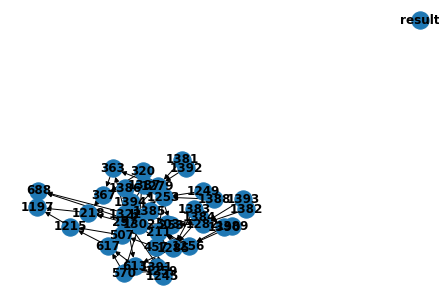

In [242]:
## This is for testing subsitution handler functions
GenJsonFromIR('/home/miao/xls/work_space/test.opt.ir',
           'test_ins.json')


In [240]:
# AutoRunAll('/home/miao/xls/work_space/all_unit_test.ir',
#            'test_ins.json',
#           '/home/miao/xls/work_space/all_unit_test_output.ir',
#            '/home/miao/xls/work_space/my_test_schedule.txt',
#           '/home/miao/xls/bazel-bin/xls/tools/RL_main')

